<b>Analiza elektrowni atomowych</b><br>
Tematem projektu są elektrownie atomowe położone w USA. Analizowałem odległość elektrowni atomowych od poszczególnych miast. Dzięki tej analizie mozna ocenić miasta potencjalnie zasilane przez daną elektrownie. Można również ocenić, które elektrownie zasilają za dużo miast i wybrać miejsca gdzie możnaby wybudować nowe elektrownie. Będziemy przeprowadzać analize dla 37447 miast oraz 66 elektrowni atomowych. Drugą analizę jaką przeprowadzono jest przeliczenie, w którym stanie znajduje się najwięcej elektrowni atomowych. Może to pomóc ocenić ryzyko odcięcia poszczególnych stanów od energii elektrycznej w przypadku destabilizacji technologii wykorzystywanych w elektrowniach atomowych. Można też ocenić, które stany są najbardziej narażone na atak ze strony wroga celującego w strategiczne punkty (np.elektrownie atomowe).

<b>Dane</b><br>
Dane są wczytywane z plików shapefiles z roszerzeniem .shp. Dane dotyczące elektrowni atomowych są pobierane z pliku 'Power_Plants.shp'. Dane dotyczące miast są pobierane z 'citiesx010g.shp', a dotyczące stanów z 'USA_States.shx'.

<b>Elektrownie atomowe</b><br>
Dane dotyczące elektrowni atomowych wczytuję z pliku 'Power_Plants.shp'. Następnie wyświetlam ich położenia.    

<AxesSubplot: >

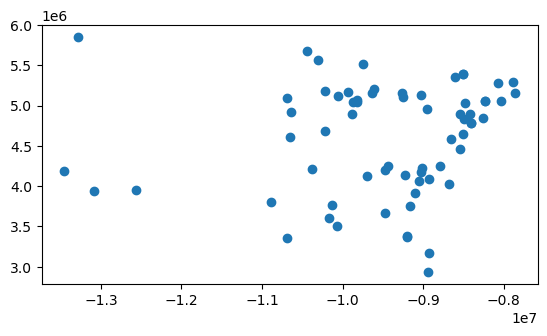

In [1]:
import geopandas as gpd

nuklear = gpd.read_file('Power_Plants.shp')
nuklear.plot()

<b>Miasta</b><br>
Dane dotyczące miast wczytuję z pliku 'citiesx010g.shp'. Przy wczytywaniu danych pomijamy stany, które nie podlegają analizie. Następnie wyświetlam ich położenia.    

<AxesSubplot: >

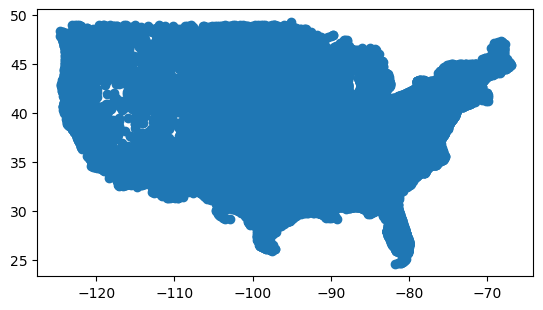

In [2]:
import geopandas as gpd

usa_cities = gpd.read_file('citiesx010g.shp')
usa_cities = usa_cities.loc[(usa_cities['STATE'] != 'HI') & (usa_cities['STATE'] != 'AK')  
                            & (usa_cities['STATE'] != 'PR') & (usa_cities['STATE'] != 'VI')]
usa_cities.plot()

<b>Stany</b><br>
Dane dotyczące stanów wczytuję z pliku 'USA_States.shp'. Przy wczytywaniu danych pomijamy stany, które nie podlegają analizie. Następnie wyświetlam mape z podziałem na stany.    

<AxesSubplot: >

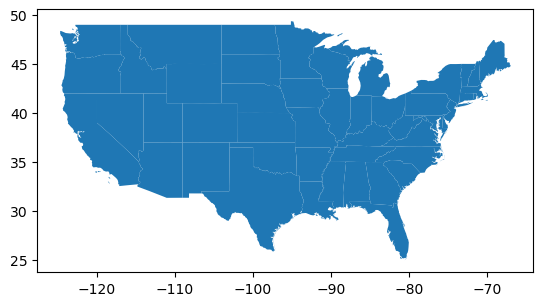

In [15]:
usa = gpd.read_file('USA_States.shp')
usa = usa.loc[(usa['STATE_NAME'] != 'Alaska') & (usa['STATE_NAME'] != 'Hawaii')]
usa.plot()

<b>CRS</b><br>
Sprawdzam czy crs dla zmiennych 'nuklear' i 'usa_cities' są takie same jak dla 'usa'. Jeżeli nie to są one ujednolicane do wartości dla zmiennej 'usa'.  

In [4]:
if(not(nuklear.crs == usa.crs and usa_cities.crs == usa.crs)):
    nuklear = nuklear.to_crs(usa.crs)
    usa_cities = usa_cities.to_crs(usa.crs)

<b>Wykres stanów wraz z miastami i elektrowniami atomowymi</b><br>
Na wspólnym wykresie o rozmiarze 14x10 umieszczam dane ze zmiennych 'usa', 'usa_cities' i 'nuklear'. Ustawiamy kolor mapy na czarny, miasta mają kolor czerwony i wielkość 0.5 oraz elektrownie atomowe kolor zielony i wielkość 50.

<AxesSubplot: >

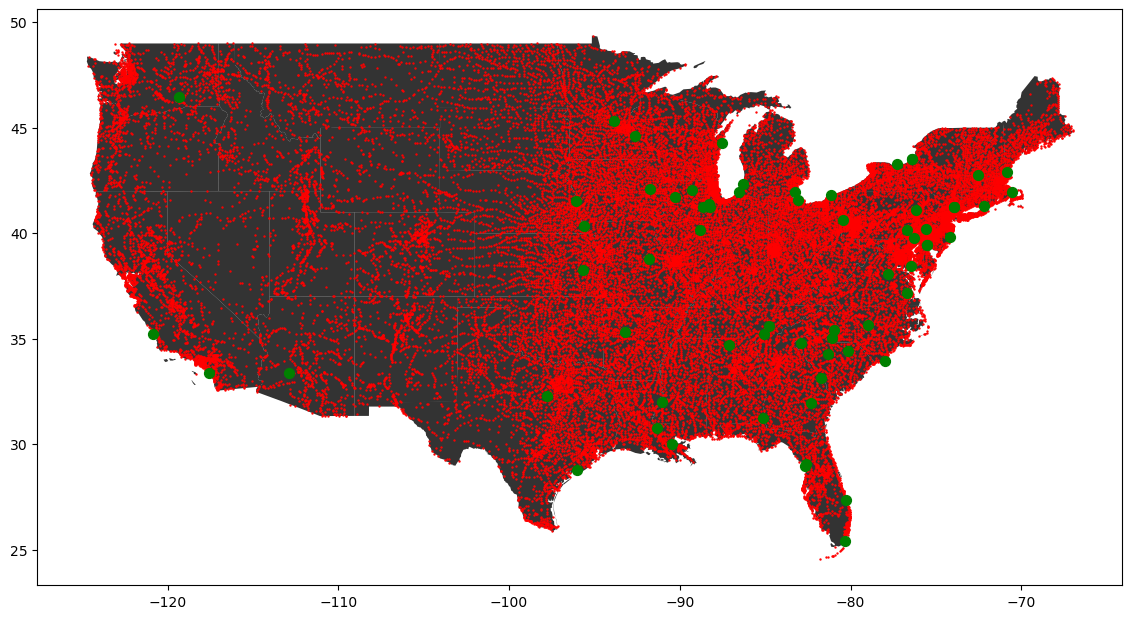

In [5]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize = (14, 10))

usa.plot(ax = ax, color = 'black', alpha = 0.8)
usa_cities.plot(ax = ax, color = 'red', markersize = 0.5)
nuklear.plot(ax = ax, color = 'green', markersize = 50)

<b>Obliczanie najbliższych elektrowni</b><br>
Tworzę fukcję 'closest_nuklear' obliczającą na podstawie podanego miasta najbliższą dla niego elektrownię. Funkcja ta zwraca nazwę najbliższej elektrowni. W funkcji wykorzystałem wbudowaną metodę <i>.distance()</i> obliczającą oddległość pomiedzy dwoma punktami. Następnie utworzyłem listę do której wpisuję wyznaczone przy pomocy mojej funkcji nazwy elektrowni. Następnie tworzę nową kolumnę w zmiennej 'usa_cities' na podstawie listy 'close_nuklear'.

In [6]:
def closest_nuklear(city):
    nuklear_tmp = nuklear['NAME'][0]
    closest = city['geometry'].distance(nuklear['geometry'][0])
    for index, row in nuklear.iterrows():
        tmp = city['geometry'].distance(row['geometry'])
        if tmp < closest:
            closest = tmp
            nuklear_tmp = row['NAME']
    return nuklear_tmp

close_nuklear = []
for index, row in usa_cities.iterrows():
    close_nuklear.append(closest_nuklear(row))
usa_cities['nuklear'] = close_nuklear

<b>Wykres najbliższych elektrownii</b><br>
Tworzę wykres dla miast od kolumny zwierającej najbliższą elektrownię. Przekrój barw ustawiam na Spectral, a rozmiar punktów na 1.

<AxesSubplot: >

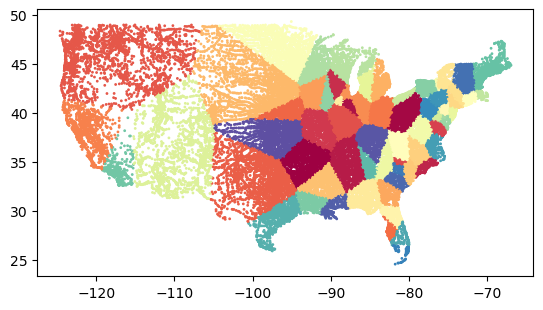

In [7]:
usa_cities.plot(column='nuklear', cmap='Spectral',markersize = 1)

<b>Uzupełniony wykres najbliższych elektrownii</b><br>
Tworzę wykres dla miast, elektrowni i stanów ukazujący podział miast w zależności od najbliższej elektrownii.

<AxesSubplot: >

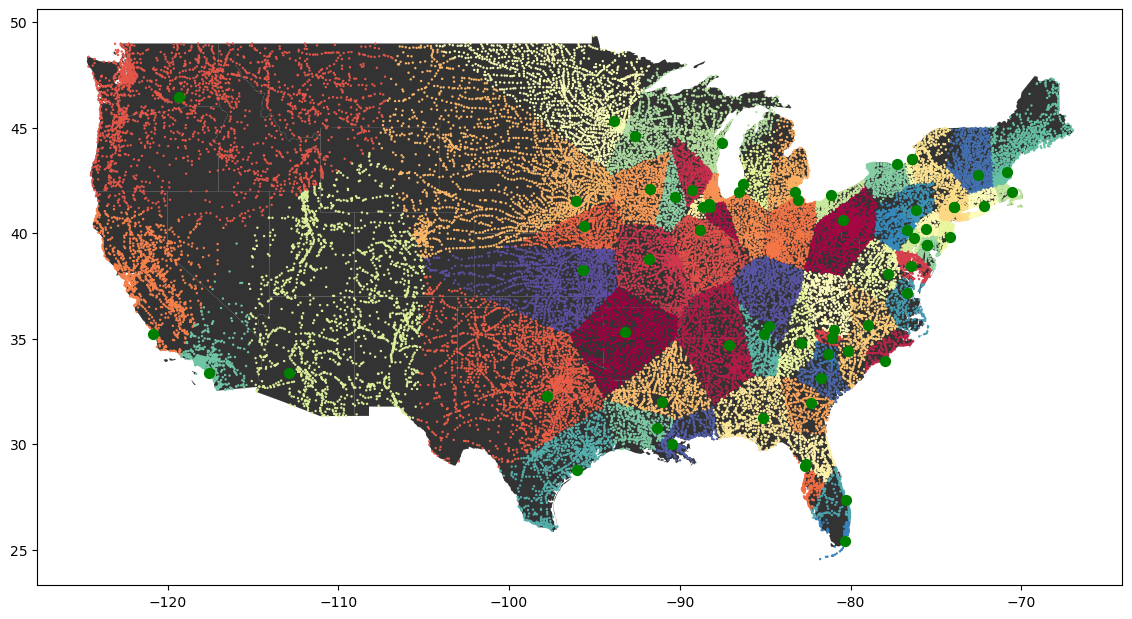

In [8]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize = (14, 10))

usa.plot(ax = ax, color = 'black', alpha = 0.8)
usa_cities.plot(ax = ax, column='nuklear', cmap='Spectral', markersize = 0.5)
nuklear.plot(ax = ax, color = 'green', markersize = 50)

<b>Wykres liczebności elektrowni w zalezności od stanu</b><br>
W zmiennej 'grouped_states' umieściłem pogrupowane po stanach liczebności występowania elektrowni atomowych. Posortowałem je malejąco, a kolumna przechowująca ich liczność nazywa się 'count'. Następnie w pętli dopasowałem odpowiednie liczebności elektrowni atomowych do odpowiednich stanów w zmiennej 'usa' i dla wszystskich stanów nie posiadającyh przydzielonej liczebności przypisaliśmy liczebność 0. Na końcu narysowaliśmy wykres stanów w zleżności od liczności występujących w nim elektrowni atomowych. Ich liczebność możemy ocenić dzięki legendzie zanjdującej sie po prawej stronie wykresu.

<AxesSubplot: >

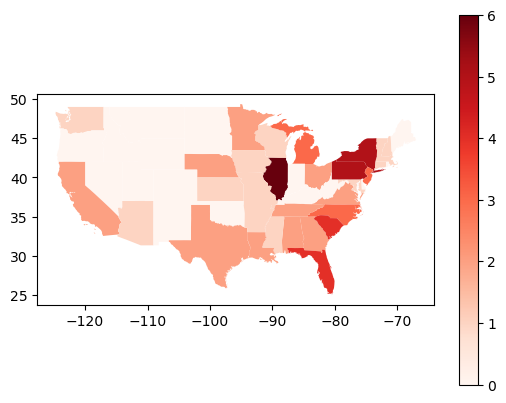

In [9]:
grouped_states = nuklear.groupby(['STATE']).size().sort_values(ascending=False).reset_index(name='count')
usa['nuclear_count'] = '' 
for index, row in grouped_states.iterrows():
    usa.loc[usa['STATE_ABBR'] == row['STATE'], 'nuclear_count'] = row['count']
usa = usa.replace("", 0)
usa.plot(column='nuclear_count', cmap='Reds', legend = True)

<b>Zmiana CRS</b><br>
Dla zmiennej 'nuklear' i 'usa_cities' ustawiliśmy crs na wartość 3857.

In [10]:
nuklear = nuklear.to_crs(3857)
usa_cities = usa_cities.to_crs(3857)

<b>Wykres najbliższych elektrowni na mapie stanów zjednoczonych</b><br>
Do wykresu najbliższych elektrownii podstawiamy mapę bazową.

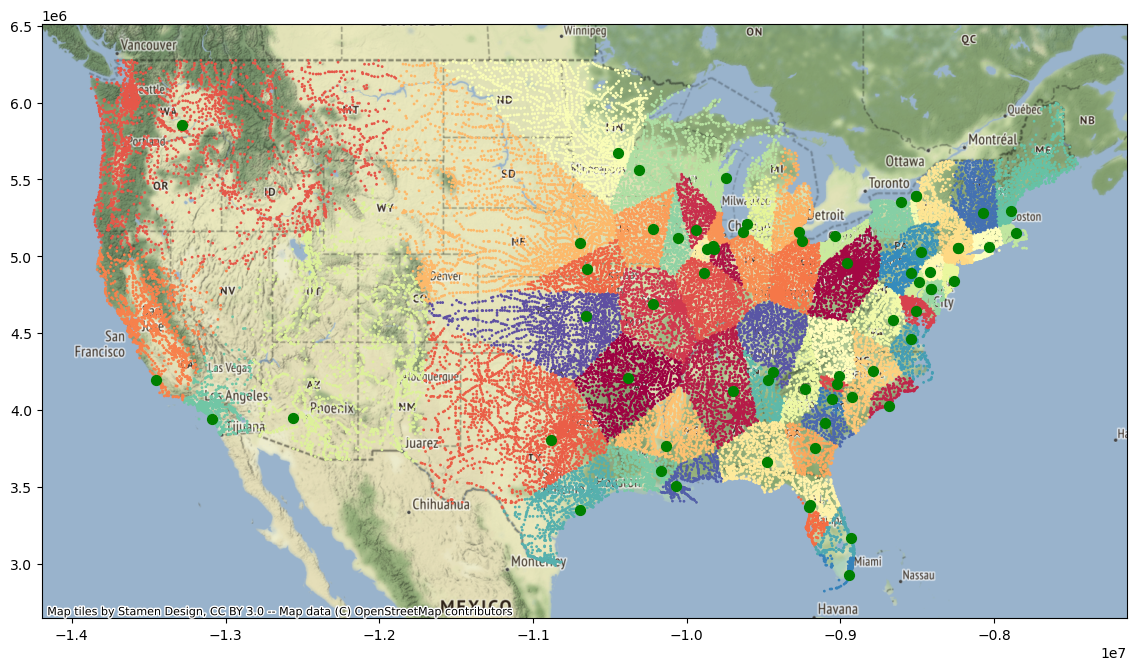

In [11]:
import matplotlib.pyplot as plt
import contextily as ctx

fix, ax = plt.subplots(figsize = (14, 10))


usa_cities.plot(ax = ax, column='nuklear', cmap='Spectral', markersize = 1)
nuklear.plot(ax = ax, color = 'green', markersize = 50)
ctx.add_basemap(ax)

<b>Najmniejsza i największa liczba miast przypisanych elektrownii</b><br>
Grupujemy w zmiennej 'usa_cities' po nazwach elektrowni i zliczamy liczbę przypisanych do nich najbliżej położonych miast. Następnie przedstawiamy liczbę miast i nazwę elektrowni o ich największej i najmnieszej liczbie.

In [14]:
grouped = usa_cities.groupby(['nuklear']).size().sort_values(ascending=False).reset_index(name='count')
print("Najbliższą elektrownią jądrową dla największej ilości miast jest:", grouped['nuklear'][0], 
      ",ich dokładna liczba to:", grouped['count'][0])
print("Najbliższą elektrownią jądrową dla najmniejszej ilości miast jest:", grouped['nuklear'].iloc[-1], 
      ",ich dokładna liczba to:", grouped['count'].iloc[-1])

Najbliższą elektrownią jądrową dla największej ilości miast jest: COLUMBIA GENERATING STATION ,ich dokładna liczba to: 2304
Najbliższą elektrownią jądrową dla najmniejszej ilości miast jest: NINE MILE POINT NUCLEAR STATION ,ich dokładna liczba to: 50


<b>Interaktywna mapa</b><br>
Korzystając z biblioteki folium tworzę mapę na przybliżonych współżędnych środka stanów zjednoczonych (40.56, -100.82). Ustawiam współczynnik początkowego przybliżenia na 4.25 oraz mapa jest w stylu kafelek cartodbpositron. Na mapie umieszczamy elktrownie atomowe w postaci zielonych icon z żółtym wzorem błyskawicy. Po naciśnięciu na konkretny znacznik można przeczytać nazwę elektrowni w wyskakującym dymku. Została dodana osługa warstw pozwalająca na ukrycie warstwy elektrowni.   

In [13]:
import folium
from folium.plugins import MarkerCluster
from folium import Popup

m = folium.Map(location = [40.56, -100.82], zoom_start=4.25, tiles='cartodbpositron')

m_c=MarkerCluster(name='Nuclear power plants').add_to(m)
for index, row in nuklear.iterrows():
    folium.Marker(
        location=[row['SOURCE_LAT'], row['SOURC_LONG']], 
        popup = Popup(row['NAME'], lazy=True), 
        icon = folium.Icon(color='green', icon_color='yellow', icon = 'glyphicon-flash')
                  ).add_to(m_c)
folium.LayerControl().add_to(m)

m